# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will train your CNN-RNN model.  

You are welcome and encouraged to try out many different architectures and hyperparameters when searching for a good model.

This does have the potential to make the project quite messy!  Before submitting your project, make sure that you clean up:
- the code you write in this notebook.  The notebook should describe how to train a single CNN-RNN architecture, corresponding to your final choice of hyperparameters.  You should structure the notebook so that the reviewer can replicate your results by running the code in this notebook.  
- the output of the code cell in **Step 2**.  The output should show the output obtained when training the model from scratch.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Training Setup
- [Step 2](#step2): Train your Model
- [Step 3](#step3): (Optional) Validate your Model

<a id='step1'></a>
## Step 1: Training Setup

In this step of the notebook, you will customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values you set now will be used when training your model in **Step 2** below.

You should only amend blocks of code that are preceded by a `TODO` statement.  **Any code blocks that are not preceded by a `TODO` statement should not be modified**.

### Task #1

Begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

If you're not sure where to begin to set some of the values above, you can peruse [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) for useful guidance!  **To avoid spending too long on this notebook**, you are encouraged to consult these suggested research papers to obtain a strong initial guess for which hyperparameters are likely to work best.  Then, train a single model, and proceed to the next notebook (**3_Inference.ipynb**).  If you are unhappy with your performance, you can return to this notebook to tweak the hyperparameters (and/or the architecture in **model.py**) and re-train your model.

### Question 1

**Question:** Describe your CNN-RNN architecture in detail.  With this architecture in mind, how did you select the values of the variables in Task 1?  If you consulted a research paper detailing a successful implementation of an image captioning model, please provide the reference.

**Answer:** 
EncoderCNN:
- I have taken the feature detector part of the pre-trained ResNet50 model with frozen weights as it is and replaced only the final encoder head with a fully-connected linear feature embedding layer plus an additional dropout layer. I have tried embedding sizes of 256 and 512. Both worked on my Geforce GTX 970M GPU, so I have chosen an embedding size of 512 - a similar setting as has been used by others, too, s. [this paper](https://arxiv.org/pdf/1411.4555.pdf) or [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning).
DecoderRNN:
- I have left the vocabulary threshold at 5 as is recommended in [this paper](https://arxiv.org/pdf/1411.4555.pdf). This threshold seems be a reasonable compromize between computational efforts, model size and prediction quality.
- I have used a setup with 1...2 hidden LSTM layers with a hidden dimension of 512 (s. also [this paper](https://arxiv.org/pdf/1411.4555.pdf) or [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning)).
- In order to reduce oszillations of training loss I have tried to increase the batch size in potency-of-2-steps starting from 16, 32 and 64. The training setup on my local machine worked well with batches of 64. In order to keep some free capacity on my GPU e. g. to test with two LSTM layers I haven't increased the batch size any further.
- As final decoder layer I have added one fully-connected linear layer to the LSTM stack, which transforms the encoded LSTM output back to the vocabulary size. I have also seen other models on internet using up to two fully-connected layers as decoder but one final layer worked fine with me. So I have kept it this way.
- For regularization I have added a dropout layer between the LSTM stack and the final fully-connected decoder layer and between two subsequent LSTM layers - provided there is more than one LSTM layer in the DecoderRNN model.


### (Optional) Task #2

Note that we have provided a recommended image transform `transform_train` for pre-processing the training images, but you are welcome (and encouraged!) to modify it as you wish.  When modifying this transform, keep in mind that:
- the images in the dataset have varying heights and widths, and 
- if using a pre-trained model, you must perform the corresponding appropriate normalization.

### Question 2

**Question:** How did you select the transform in `transform_train`?  If you left the transform at its provided value, why do you think that it is a good choice for your CNN architecture?

**Answer:** 
- Using data augmentation one can noticably increase the size of the training dataset and make the trained model more robust against various effects (e. g. added noise, color jitter, image rotation, ...) that can also be generated artifically in a realistic way.
- On the one hand, data augmentation using random manipulation (e. g. randomly resizing, cropping, flipping, rotating or adding noise) only makes sense when performing many epochs of training what also increases processing time and cost. If we crop a section of an image randomly, for instance, we may clip off meaningful contents. In order to pass all the image contents step by step to the training process without loosing too much information, we need to feed many overlapping random crops of the same image into training so that most of the original image is covered by all cropped image parts. This usually requires a very large number of repetitions.
- On the other hand, when resources are limited and the training dataset is large enough to achieve the desired results it is reasonable to stick with no augmentation at all or or at maximum some random augmentation with small modifications only.
- So when keeping the number of training iterations low in this case the proposed image transforms including resizing, random cropping and random flipping seem to be sufficient. However, in my personal opinion I would not do random cropping but rather resizing of both sides of the full image accepting distortion to have all image contents being considered in the training process.
- When increasing the number of training iterations (after hyperparameter tuning and finding a good setup) one can add more modifications e. g. random rotation, some other affine transformations or maybe adding noise or color jitter. However, this may also require fine tuning of the feature detector part of the encoder as it may not have been trained in depth e. g. on rotated images.
- I would propose to add random rotation with a small rotation angle of approx. +/- 8° here, which requires another resizing and center cropping transform to prevent black triangles from appearing at the rims of the rotated image due to zero-padding. I would also propose to add some color jitter - especially brightness jitter. However, this will likely have noticable effects only when performing very large number of iterations (>> 100).

### Task #3

Next, you will specify a Python list containing the learnable parameters of the model.  For instance, if you decide to make all weights in the decoder trainable, but only want to train the weights in the embedding layer of the encoder, then you should set `params` to something like:
```
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
```

### Question 3

**Question:** How did you select the trainable parameters of your architecture?  Why do you think this is a good choice?

**Answer:**
- ResNet50 or other pre-trained object detection CNNs already provide quite good performance. If we exchange the encoder head of the pre-trained CNN and freeze the weights of the feature detector part we already get good results with low computational efforts for training. Therefore, it seems sufficient to me to follow above recommendation and keep the weights of the CNN's feature detector part frozen because there are no special performance requirements for this task.
- When optimizing or fine tuning the whole encoder-decoder setup to achieve a overall better performance I would reactivate the weights of the feature detector part of the encoder CNN for training. But I didn't do that here.

### Task #4

Finally, you will select an [optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Optimizer).

### Question 4

**Question:** How did you select the optimizer used to train your model?

**Answer:** 
- I have tested stochastic gradient (SGD) descent and Adam optimizer with the same learning rates. As SGD resulted in much higher losses over the first 3 batches I have chosen to continue with Adam optimizer only.
- Adam seems to work fine with a learning rate of 1e-3 as a starter. Other authors (s. reference) use smaller and different learning rates for encoder (1e-4) and decoder (4e-4) fine tuning.

- When training with a fixed learning rate of 1e-3 ... 5e-4 with Adam optimizer and regularization with a dropout probability of about 30%, training and validation loss drop down quickly over the first 3 epochs and then degress afterwards. Further optimization really needs many more iterations, and the optimization seems to get easily stuck in local minima. Therefore, it seems reasonable to chose rather larger values for dropout probability to 40...50% especially for the decoder RNN part. The final layer of the encoder CNN can also be trained well without dropout.

### Reference
I have used the following links as additional source of information for completing this project:
- [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning): In my opinion, this is a very good and recommendable tutorial on image captioning by Sagar Vinodababu using a similar setup as in this project. However, the tutorial goes beyond this project as it also includes an additional attention model.

### Set Hyperparameters, Initialize Encoder and Decoder Model and Load Training Dataset

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
sys.path.append('/home/andreas/data/coco/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader_train_val_test import get_loader
from model import EncoderCNN, DecoderRNN
import math

import matplotlib.pyplot as plt
%matplotlib inline


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 64             # batch size (16...64)
#batch_size = 32             # batch size (16...64)
vocab_threshold = 5         # minimum word count threshold
vocab_from_file = False     # if True, load existing vocab file
#embed_size = 256            # dimensionality of image and word embeddings
embed_size = 512            # dimensionality of image and word embeddings
hidden_size = 512           # number of features in hidden state of the RNN decoder
num_lstm_layers = 1         # number of lstm layers in the RNN decoder
#num_lstm_layers = 2         # number of lstm layers in the RNN decoder
p_dropout_enc = 0.3         # dropout probability for the CNN encoder
p_dropout_dec = 0.3         # dropout probability for the RNN decoder
#p_dropout_dec = 0.5         # dropout probability for the RNN decoder
#learning_rate = 5e-4        # learning rate
learning_rate = 1e-3        # learning rate
num_epochs = 5              # number of training epochs
#num_epochs = 10             # number of training epochs
save_every = 1              # determines frequency of saving model weights
print_every = 100           # determines window for printing average loss
log_file = 'log.txt'        # name of file with saved training loss and perplexity


## Load training dataset for mini-batch training

# Calculate allowable random rotation angle: The rotation angle range is bounded by the resize
# and center crop dimensions in order to avoid blackened triangles to appear at the rim of the 
# rotated image
max_rot_angle = 180/math.pi*math.asin((256-224)/224)
max_rot_angle = math.floor(max_rot_angle)
print('Maximum rotation angle = ', max_rot_angle)

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize((256,256)),                     # resize both edges of the image to 256 accepting distortion
    transforms.RandomHorizontalFlip(),                # horizontally flip image with probability=0.5    
    transforms.RandomRotation(degrees=max_rot_angle), # random rotate within a range bounded by resized image
    transforms.CenterCrop(224),                       # center crop to avoid black triangles due to rotation
    transforms.ToTensor(),                            # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),       # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
"""
transform_train = transforms.Compose([ 
    transforms.Resize(256),                           # smaller edge of image resized to 256
    transforms.RandomCrop(224),                       # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),                # horizontally flip image with probability=0.5
    transforms.ToTensor(),                            # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),       # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

transform_train = transforms.Compose([ 
    transforms.Resize((256,256)),                     # resize both edges of the image to 256 accepting distortion
    transforms.RandomHorizontalFlip(),                # horizontally flip image with probability=0.5    
    transforms.RandomRotation(degrees=max_rot_angle), # random rotate within a range bounded by resized image
    transforms.CenterCrop(224),                       # center crop to avoid black triangles due to rotation
    transforms.ColorJitter(brightness=0.3,            # jitter brightness_factor uniformly within [max(0, 1-brightness), 1+brightness] 
                           contrast=0.1,              # jitter contrast_factor uniformly within [max(0, 1-contrast), 1+contrast]
                           saturation=0.1,            # jitter saturation_factor uniformly within [max(0, 1-saturation), 1+saturation]
                           hue=0.1),                  # jitter hue_factor uniformly within [-hue, hue]
    transforms.ToTensor(),                            # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),       # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
"""

# Build train data loader.
train_data_loader = get_loader(transform=transform_train,
                               mode='train',
                               batch_size=batch_size,
                               vocab_threshold=vocab_threshold,
                               vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(train_data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size, p_dropout=p_dropout_enc)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=num_lstm_layers, p_dropout=p_dropout_dec)

# Check for availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('\nDevice: ', device, '\n')

# Move models to GPU if CUDA is available. 
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
learnable_params = list(encoder.embed.parameters()) + list(decoder.parameters())

# TODO #4: Define the optimizer
#optimizer = torch.optim.SGD(learnable_params, lr=learning_rate)
optimizer = torch.optim.Adam(learnable_params, lr=learning_rate)

# Set the total number of training steps per epoch.
total_train_steps = math.ceil(len(train_data_loader.dataset.caption_lengths) / \
                              train_data_loader.batch_sampler.batch_size)

Maximum rotation angle =  8
Data loader called in train-mode.
loading annotations into memory...
Done (t=1.12s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.55s)
creating index...


  0%|          | 917/414113 [00:00<00:45, 9164.09it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:42<00:00, 9786.79it/s] 



Device:  cuda 



### Load Validation Data Set

In [2]:
## Load validation dataset for mini-batch validation

# Define image transform for validation
transform_val = transforms.Compose([ 
    transforms.Resize((224,224)),                    # resize both edges of the image to 224 accepting distortion
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
"""
transform_train = transforms.Compose([ 
    transforms.Resize((256,256)),                     # resize both edges of the image to 256 accepting distortion
    transforms.RandomHorizontalFlip(),                # horizontally flip image with probability=0.5    
    transforms.RandomRotation(degrees=max_rot_angle), # random rotate within a range bounded by resized image
    transforms.CenterCrop(224),                       # center crop to avoid black triangles due to rotation
    transforms.ToTensor(),                            # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),       # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

transform_val = transforms.Compose([ 
    transforms.Resize((256,256)),                     # resize both edges of the image to 256 accepting distortion
    transforms.RandomHorizontalFlip(),                # horizontally flip image with probability=0.5    
    transforms.RandomRotation(degrees=max_rot_angle), # random rotate within a range bounded by resized image
    transforms.CenterCrop(224),                       # center crop to avoid black triangles due to rotation
    transforms.ColorJitter(brightness=0.3,            # jitter brightness_factor uniformly within [max(0, 1-brightness), 1+brightness] 
                           contrast=0.1,              # jitter contrast_factor uniformly within [max(0, 1-contrast), 1+contrast]
                           saturation=0.1,            # jitter saturation_factor uniformly within [max(0, 1-saturation), 1+saturation]
                           hue=0.1),                  # jitter hue_factor uniformly within [-hue, hue]
    transforms.ToTensor(),                            # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),       # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
"""

# Build validation data loader.
val_data_loader = get_loader(transform=transform_val,         # Use image transform for validation
                             mode='batch-val',                # Set to batch-validation mode
                             batch_size=batch_size,           # Use training batch size
                             vocab_threshold=vocab_threshold, # Keep vocab_threshold
                             vocab_from_file=True)            # True: load existing training vocabulary

# Set the total number of validation steps per epoch.
total_val_steps = math.ceil(len(val_data_loader.dataset.caption_lengths) / \
                              val_data_loader.batch_sampler.batch_size)

Data loader called in batch-val-mode.
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


  0%|          | 847/202654 [00:00<00:23, 8465.81it/s]

Done (t=0.72s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:20<00:00, 9747.12it/s] 


<a id='step2'></a>
## Step 2: Train your Model

Once you have executed the code cell in **Step 1**, the training procedure below should run without issue.  

It is completely fine to leave the code cell below as-is without modifications to train your model.  However, if you would like to modify the code used to train the model below, you must ensure that your changes are easily parsed by your reviewer.  In other words, make sure to provide appropriate comments to describe how your code works!  

You may find it useful to load saved weights to resume training.  In that case, note the names of the files containing the encoder and decoder weights that you'd like to load (`encoder_file` and `decoder_file`).  Then you can load the weights by using the lines below:

```python
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
```

While trying out parameters, make sure to take extensive notes and record the settings that you used in your various training runs.  In particular, you don't want to encounter a situation where you've trained a model for several hours but can't remember what settings you used :).

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training - and for the purposes of this project, you are encouraged to amend the hyperparameters based on this information.  

However, this will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  

For this project, you need not worry about overfitting. **This project does not have strict requirements regarding the performance of your model**, and you just need to demonstrate that your model has learned **_something_** when you generate captions on the test data.  For now, we strongly encourage you to train your model for the suggested 3 epochs without worrying about performance; then, you should immediately transition to the next notebook in the sequence (**3_Inference.ipynb**) to see how your model performs on the test data.  If your model needs to be changed, you can come back to this notebook, amend hyperparameters (if necessary), and re-train the model.

That said, if you would like to go above and beyond in this project, you can read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).  In the next (optional) step of this notebook, we provide some guidance for assessing the performance on the validation dataset.

In [3]:
# Load existing encoder and decoder models with above defined structure incl. the last optimizer states 
# to continue training with the same or different hyperparameters
import os

# Specify the last epoch where to resume training
prev_epochs = 0
if prev_epochs > 0:
    # Calculate remaining number of epochs
    remaining_epochs = num_epochs - prev_epochs
    if prev_epochs >= num_epochs:
        print('Error: Cannot resume training!')
        print('num_epochs (= {}) must be larger than last_epoch (= {})'.format(num_epochs, prev_epochs))
    else:
        print('Resume training ...')
        print('Number of epochs to train:   {}'.format(num_epochs))
        print('Previous epochs of training: {}'.format(prev_epochs))
        print('Remaining number of epochs:  {}'.format(remaining_epochs))
        
        # Specify the saved pre-trained models and optimizer states to load.
        encoder_filepath = os.path.join('./models', 'encoder-' + str(prev_epochs) + '.pkl')
        decoder_filepath = os.path.join('./models', 'decoder-' + str(prev_epochs) + '.pkl')
        optimizer_filepath = os.path.join('./models', 'optimizer-' + str(prev_epochs) + '.pkl')
        print('Load encoder model from:    {}'.format(encoder_filepath))
        print('Load decoder model from:    {}'.format(decoder_filepath))
        print('Load optimizer states from: {}'.format(optimizer_filepath))
        
        # Load pre-trained model parameters and the last state of the optimizer to resume training
        # and map the location to the current device. This is necessary when the models have been
        # saved on cuda but are loaded on cpu (if cuda is not available).
        encoder.load_state_dict(torch.load(encoder_filepath, map_location=device))
        decoder.load_state_dict(torch.load(decoder_filepath, map_location=device))
        optimizer.load_state_dict(torch.load(optimizer_filepath, map_location=device))
else:
    print('Start training of new models from scratch ...')

Start training of new models from scratch ...


In [4]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# Override total training steps for quick testing
# total_train_steps = 2
# total_val_steps = 2

# Start measuring computation time for training and validation
t_start = time.time()

# Open the log file.
f = open(log_file, 'w')

"""
old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})
"""

# Initialize minimal average validation loss encountered in training/validation history
min_val_loss = float('inf')

# Initialize model_checkpoint (epoch)
checkpoint = 0

# Initialize empty lists for training and validation loss history over all epochs
train_loss_history = list()
val_loss_history = list()

# Loop over specified epochs
for epoch in range(prev_epochs+1, num_epochs+1):
    
    ########################################  Training  ########################################
    
    # Set encoder and decoder model to training mode (gradients and dropout switched on)
    encoder.train()
    decoder.train()
    
    # Initial moving average training and validation loss over all batches per epoch
    avg_train_loss = 0
    avg_val_loss = 0
    
    # Start training loop
    print('Epoch [{}/{}]: Start training loop ...'.format(epoch, num_epochs))
    # Print message to log file.
    f.write('Epoch [{}/{}]: Start training loop ...'.format(epoch, num_epochs) + '\n')
    f.flush()
    
    # Loop over all training batches per epoch
    for i_step in range(1, total_train_steps+1):
        """
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
        """
        # Randomly sample a caption length, and sample indices with that length.
        indices = train_data_loader.dataset.get_train_indices()
        
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        train_data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain another batch of (image, caption) pairs with the same caption sequence length
        images, captions = next(iter(train_data_loader))
        
        # Get current caption sequence length
        seq_len = captions.size(1)

        # Move batch of images and tokenized captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        train_loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Calculate and store moving average train loss over all batches
        avg_train_loss = avg_train_loss * (i_step - 1) / i_step + train_loss.item() / i_step
        
        # Backward pass.
        train_loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
        
        # Get training statistics.        
        train_stats_format_strings = ['Epoch [{0:d}/{1:d}]',
                                      'Step [{2:d}/{3:d}]',
                                      'Seq_len: {4:d}',
                                      'Batch Loss: {5:.4f}',
                                      'Perplexity: {6:5.4f}',
                                      'Avg. Train Loss: {7:.4f}']
        train_stats_arguments = (epoch, num_epochs, 
                                 i_step, total_train_steps, 
                                 seq_len,
                                 train_loss.item(), 
                                 np.exp(train_loss.item()), 
                                 avg_train_loss)
        train_stats = ', '.join(train_stats_format_strings).format(*train_stats_arguments)
        
        # Print training statistics (on same line).
        print('\r' + train_stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to log file.
        f.write(train_stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + train_stats)
    
    # Finish training loop
    print('\n' + 'Epoch [{}/{}]: ... training loop finished.'.format(epoch, num_epochs))
    # Print message to log file.
    f.write('Epoch [{}/{}]: ... training loop finished.'.format(epoch, num_epochs) + '\n')
    f.flush()
    
    # Append moving average training loss to training loss history
    train_loss_history.append(avg_train_loss)
    
    ######################################## Validation ########################################
    
    # Set encoder and decoder model to evaluation mode (dropout switched off)
    encoder.eval()
    decoder.eval()
    
    ## Start validation loop
    print('Epoch [{}/{}]: Start validation loop ...'.format(epoch, num_epochs))
    # Print message to log file.
    f.write('Epoch [{}/{}]: Start validation loop ...'.format(epoch, num_epochs) + '\n')
    f.flush()
    
    # Loop over all validation batches per epoch
    for i_step in range(1, total_val_steps+1):
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = val_data_loader.dataset.get_train_indices()
        
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        val_data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain another batch of (image, caption) pairs with the same caption sequence length
        images, captions = next(iter(val_data_loader))
        
        # Get current caption sequence length
        seq_len = captions.size(1)
        
        # Move batch of images and tokenized captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Switch off gradients for the sake of efficiency
        with torch.no_grad():
            
            # Pass the inputs through the CNN-RNN model.
            features = encoder(images)
            outputs = decoder(features, captions)
            
            # Calculate the batch loss.
            val_loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
            
        # Calculate and store moving average validation loss over all batches
        avg_val_loss = avg_val_loss * (i_step - 1) / i_step + val_loss.item() / i_step
        
        # Get validation statistics.
        val_stats_format_strings = ['Epoch [{0:d}/{1:d}]', 
                                   'Step [{2:d}/{3:d}]', 
                                   'Seq_len: {4:d}', 
                                   'Batch Loss: {5:.4f}', 
                                   'Perplexity: {6:5.4f}', 
                                   'Avg. Val. Loss: {7:.4f}']
        val_stats_arguments = (epoch, num_epochs, 
                               i_step, total_val_steps, 
                               seq_len, 
                               val_loss.item(), 
                               np.exp(val_loss.item()), 
                               avg_val_loss)
        val_stats = ', '.join(val_stats_format_strings).format(*val_stats_arguments)
        
        # Print validation statistics (on same line).
        print('\r' + val_stats, end="")
        sys.stdout.flush()
        
        # Print validation statistics to file.
        f.write(val_stats + '\n')
        f.flush()
        
        # Print validation statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + val_stats)
            
    # Finish validation loop
    print('\n' + 'Epoch [{}/{}]: ... validation loop finished.'.format(epoch, num_epochs))
    # Print message to log file.
    f.write('Epoch [{}/{}]: ... validation loop finished.'.format(epoch, num_epochs) + '\n')
    f.flush()
    
    # Append moving average validation loss to training loss history
    val_loss_history.append(avg_val_loss)
        
    # Save the model weights and optimizer states for later use.
    if (epoch % save_every == 0) and (avg_val_loss < min_val_loss):
        # Save last checkpoint (epoch)
        checkpoint = epoch
        # Display decrease of validation loss with respect to the last checkpoint
        print('Validation loss has decreased from {} to {} ... '.format(min_val_loss, avg_val_loss))
        # Specify the filepaths for the model and optimizer checkpoints
        encoder_filepath = os.path.join('./models', 'encoder-' + str(epoch) + '.pkl')
        decoder_filepath = os.path.join('./models', 'decoder-' + str(epoch) + '.pkl')
        optimizer_filepath = os.path.join('./models', 'optimizer-' + str(epoch) + '.pkl')
        print('... save encoder checkpoint as:   {}'.format(encoder_filepath))
        print('... save decoder checkpoint as:   {}'.format(decoder_filepath))
        print('... save optimizer checkpoint as: {}'.format(optimizer_filepath))
        # Save encoder parameters (weights, biases, ...) as state dictionary
        torch.save(encoder.state_dict(), encoder_filepath)
        # Save decoder parameters (weights, biases, ...) as state dictionary
        torch.save(decoder.state_dict(), decoder_filepath)
        # Save the optimizer states to pick up training of an existing model at a later point of time
        torch.save(optimizer.state_dict(), optimizer_filepath)
    
    # Update minimum validation loss
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss

# Stop measuring computation time for training and validation
t_stop = time.time()

# Print computation time
print('Comupation time for {0:d} epochs: {1:6.4e} s'.format(num_epochs-prev_epochs, t_stop-t_start))
# Print message to log file.
f.write('\n' + \
        'Comupation time for {0:d} epochs: {1:6.4e} s'.format(num_epochs-prev_epochs, t_stop-t_start) + \
        '\n')
f.flush()  

# Close the log file.
f.close()

Epoch [1/5]: Start training loop ...
Epoch [1/5], Step [100/6471], Seq_len: 13, Batch Loss: 4.1352, Perplexity: 62.5046, Avg. Train Loss: 4.8691
Epoch [1/5], Step [200/6471], Seq_len: 20, Batch Loss: 4.4705, Perplexity: 87.4011, Avg. Train Loss: 4.40253
Epoch [1/5], Step [300/6471], Seq_len: 11, Batch Loss: 3.4328, Perplexity: 30.9644, Avg. Train Loss: 4.1388
Epoch [1/5], Step [400/6471], Seq_len: 14, Batch Loss: 3.0587, Perplexity: 21.2996, Avg. Train Loss: 3.9753
Epoch [1/5], Step [500/6471], Seq_len: 13, Batch Loss: 3.1027, Perplexity: 22.2584, Avg. Train Loss: 3.86059
Epoch [1/5], Step [600/6471], Seq_len: 14, Batch Loss: 3.0860, Perplexity: 21.8904, Avg. Train Loss: 3.7658
Epoch [1/5], Step [700/6471], Seq_len: 11, Batch Loss: 3.0676, Perplexity: 21.4895, Avg. Train Loss: 3.6883
Epoch [1/5], Step [800/6471], Seq_len: 10, Batch Loss: 3.3124, Perplexity: 27.4507, Avg. Train Loss: 3.6218
Epoch [1/5], Step [900/6471], Seq_len: 12, Batch Loss: 3.2193, Perplexity: 25.0100, Avg. Train Lo

Epoch [1/5], Step [1000/3167], Seq_len: 15, Batch Loss: 2.4143, Perplexity: 11.1824, Avg. Val. Loss: 2.3209
Epoch [1/5], Step [1100/3167], Seq_len: 11, Batch Loss: 2.2180, Perplexity: 9.1890, Avg. Val. Loss: 2.32146
Epoch [1/5], Step [1200/3167], Seq_len: 12, Batch Loss: 2.1860, Perplexity: 8.8999, Avg. Val. Loss: 2.31794
Epoch [1/5], Step [1300/3167], Seq_len: 11, Batch Loss: 2.3118, Perplexity: 10.0929, Avg. Val. Loss: 2.3176
Epoch [1/5], Step [1400/3167], Seq_len: 11, Batch Loss: 2.3573, Perplexity: 10.5620, Avg. Val. Loss: 2.3143
Epoch [1/5], Step [1500/3167], Seq_len: 13, Batch Loss: 2.1028, Perplexity: 8.1894, Avg. Val. Loss: 2.31082
Epoch [1/5], Step [1600/3167], Seq_len: 13, Batch Loss: 2.1746, Perplexity: 8.7991, Avg. Val. Loss: 2.30780
Epoch [1/5], Step [1700/3167], Seq_len: 12, Batch Loss: 2.3877, Perplexity: 10.8882, Avg. Val. Loss: 2.3061
Epoch [1/5], Step [1800/3167], Seq_len: 13, Batch Loss: 2.1557, Perplexity: 8.6337, Avg. Val. Loss: 2.30590
Epoch [1/5], Step [1900/3167

Epoch [2/5], Step [5000/6471], Seq_len: 13, Batch Loss: 2.2887, Perplexity: 9.8623, Avg. Train Loss: 2.26045
Epoch [2/5], Step [5100/6471], Seq_len: 11, Batch Loss: 2.0962, Perplexity: 8.1351, Avg. Train Loss: 2.25936
Epoch [2/5], Step [5200/6471], Seq_len: 15, Batch Loss: 2.1680, Perplexity: 8.7411, Avg. Train Loss: 2.25844
Epoch [2/5], Step [5300/6471], Seq_len: 12, Batch Loss: 2.1281, Perplexity: 8.3987, Avg. Train Loss: 2.25745
Epoch [2/5], Step [5400/6471], Seq_len: 12, Batch Loss: 2.3061, Perplexity: 10.0354, Avg. Train Loss: 2.2560
Epoch [2/5], Step [5500/6471], Seq_len: 9, Batch Loss: 2.3356, Perplexity: 10.3354, Avg. Train Loss: 2.25488
Epoch [2/5], Step [5600/6471], Seq_len: 13, Batch Loss: 1.9972, Perplexity: 7.3685, Avg. Train Loss: 2.25378
Epoch [2/5], Step [5700/6471], Seq_len: 11, Batch Loss: 2.1470, Perplexity: 8.5592, Avg. Train Loss: 2.25267
Epoch [2/5], Step [5800/6471], Seq_len: 15, Batch Loss: 2.3011, Perplexity: 9.9856, Avg. Train Loss: 2.25188
Epoch [2/5], Step [

Epoch [3/5], Step [2400/6471], Seq_len: 11, Batch Loss: 2.0868, Perplexity: 8.0590, Avg. Train Loss: 2.17477
Epoch [3/5], Step [2500/6471], Seq_len: 13, Batch Loss: 2.1407, Perplexity: 8.5050, Avg. Train Loss: 2.17370
Epoch [3/5], Step [2600/6471], Seq_len: 15, Batch Loss: 2.1429, Perplexity: 8.5242, Avg. Train Loss: 2.17268
Epoch [3/5], Step [2700/6471], Seq_len: 14, Batch Loss: 2.1040, Perplexity: 8.1990, Avg. Train Loss: 2.17333
Epoch [3/5], Step [2800/6471], Seq_len: 13, Batch Loss: 1.9751, Perplexity: 7.2073, Avg. Train Loss: 2.17371
Epoch [3/5], Step [2900/6471], Seq_len: 13, Batch Loss: 2.1363, Perplexity: 8.4681, Avg. Train Loss: 2.17358
Epoch [3/5], Step [3000/6471], Seq_len: 13, Batch Loss: 2.0334, Perplexity: 7.6400, Avg. Train Loss: 2.17177
Epoch [3/5], Step [3100/6471], Seq_len: 12, Batch Loss: 1.9219, Perplexity: 6.8338, Avg. Train Loss: 2.17201
Epoch [3/5], Step [3200/6471], Seq_len: 13, Batch Loss: 2.0040, Perplexity: 7.4189, Avg. Train Loss: 2.17190
Epoch [3/5], Step [

Epoch [4/5], Step [100/6471], Seq_len: 13, Batch Loss: 2.0583, Perplexity: 7.8323, Avg. Train Loss: 2.1322
Epoch [4/5], Step [200/6471], Seq_len: 15, Batch Loss: 2.0514, Perplexity: 7.7790, Avg. Train Loss: 2.13075
Epoch [4/5], Step [300/6471], Seq_len: 10, Batch Loss: 2.2031, Perplexity: 9.0533, Avg. Train Loss: 2.12646
Epoch [4/5], Step [400/6471], Seq_len: 18, Batch Loss: 2.3911, Perplexity: 10.9258, Avg. Train Loss: 2.1292
Epoch [4/5], Step [500/6471], Seq_len: 12, Batch Loss: 1.9619, Perplexity: 7.1127, Avg. Train Loss: 2.13070
Epoch [4/5], Step [600/6471], Seq_len: 18, Batch Loss: 2.5403, Perplexity: 12.6831, Avg. Train Loss: 2.1283
Epoch [4/5], Step [700/6471], Seq_len: 15, Batch Loss: 2.2458, Perplexity: 9.4481, Avg. Train Loss: 2.13024
Epoch [4/5], Step [800/6471], Seq_len: 10, Batch Loss: 2.3216, Perplexity: 10.1921, Avg. Train Loss: 2.1282
Epoch [4/5], Step [900/6471], Seq_len: 15, Batch Loss: 2.1057, Perplexity: 8.2132, Avg. Train Loss: 2.12766
Epoch [4/5], Step [1000/6471]

Epoch [4/5], Step [1000/3167], Seq_len: 13, Batch Loss: 1.9807, Perplexity: 7.2480, Avg. Val. Loss: 2.1658
Epoch [4/5], Step [1100/3167], Seq_len: 13, Batch Loss: 2.1295, Perplexity: 8.4105, Avg. Val. Loss: 2.16688
Epoch [4/5], Step [1200/3167], Seq_len: 13, Batch Loss: 1.9985, Perplexity: 7.3778, Avg. Val. Loss: 2.16745
Epoch [4/5], Step [1300/3167], Seq_len: 21, Batch Loss: 2.6935, Perplexity: 14.7840, Avg. Val. Loss: 2.1652
Epoch [4/5], Step [1400/3167], Seq_len: 13, Batch Loss: 2.2003, Perplexity: 9.0277, Avg. Val. Loss: 2.16566
Epoch [4/5], Step [1500/3167], Seq_len: 11, Batch Loss: 2.0952, Perplexity: 8.1270, Avg. Val. Loss: 2.16703
Epoch [4/5], Step [1600/3167], Seq_len: 11, Batch Loss: 2.1581, Perplexity: 8.6546, Avg. Val. Loss: 2.16849
Epoch [4/5], Step [1700/3167], Seq_len: 16, Batch Loss: 2.2926, Perplexity: 9.9009, Avg. Val. Loss: 2.17087
Epoch [4/5], Step [1800/3167], Seq_len: 13, Batch Loss: 2.1605, Perplexity: 8.6750, Avg. Val. Loss: 2.16968
Epoch [4/5], Step [1900/3167]

Epoch [5/5], Step [5000/6471], Seq_len: 14, Batch Loss: 1.9664, Perplexity: 7.1449, Avg. Train Loss: 2.06190
Epoch [5/5], Step [5100/6471], Seq_len: 13, Batch Loss: 1.9981, Perplexity: 7.3753, Avg. Train Loss: 2.06222
Epoch [5/5], Step [5200/6471], Seq_len: 12, Batch Loss: 2.0404, Perplexity: 7.6939, Avg. Train Loss: 2.06166
Epoch [5/5], Step [5300/6471], Seq_len: 11, Batch Loss: 2.2008, Perplexity: 9.0321, Avg. Train Loss: 2.06166
Epoch [5/5], Step [5400/6471], Seq_len: 9, Batch Loss: 2.1783, Perplexity: 8.8315, Avg. Train Loss: 2.061716
Epoch [5/5], Step [5500/6471], Seq_len: 15, Batch Loss: 2.2122, Perplexity: 9.1355, Avg. Train Loss: 2.06199
Epoch [5/5], Step [5600/6471], Seq_len: 13, Batch Loss: 1.8479, Perplexity: 6.3463, Avg. Train Loss: 2.06200
Epoch [5/5], Step [5700/6471], Seq_len: 14, Batch Loss: 2.1947, Perplexity: 8.9769, Avg. Train Loss: 2.06167
Epoch [5/5], Step [5800/6471], Seq_len: 13, Batch Loss: 1.8948, Perplexity: 6.6515, Avg. Train Loss: 2.06177
Epoch [5/5], Step [

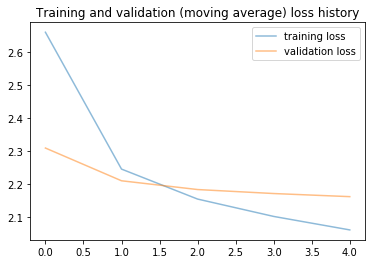

In [5]:
# Plot training and validation (moving average) loss history
fig, ax = plt.subplots()
plt.plot(train_loss_history, label='training loss', alpha=0.5)
plt.plot(val_loss_history, label='validation loss', alpha=0.5)
plt.title("Training and validation (moving average) loss history")
plt.legend()

<a id='step3'></a>
## Step 3: (Optional) Validate your Model

To assess potential overfitting, one approach is to assess performance on a validation set.  If you decide to do this **optional** task, you are required to first complete all of the steps in the next notebook in the sequence (**3_Inference.ipynb**); as part of that notebook, you will write and test code (specifically, the `sample` method in the `DecoderRNN` class) that uses your RNN decoder to generate captions.  That code will prove incredibly useful here. 

If you decide to validate your model, please do not edit the data loader in **data_loader.py**.  Instead, create a new file named **data_loader_val.py** containing the code for obtaining the data loader for the validation data.  You can access:
- the validation images at filepath `'/opt/cocoapi/images/train2014/'`, and
- the validation image caption annotation file at filepath `'/opt/cocoapi/annotations/captions_val2014.json'`.

The suggested approach to validating your model involves creating a json file such as [this one](https://github.com/cocodataset/cocoapi/blob/master/results/captions_val2014_fakecap_results.json) containing your model's predicted captions for the validation images.  Then, you can write your own script or use one that you [find online](https://github.com/tylin/coco-caption) to calculate the BLEU score of your model.  You can read more about the BLEU score, along with other evaluation metrics (such as TEOR and Cider) in section 4.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf).  For more information about how to use the annotation file, check out the [website](http://cocodataset.org/#download) for the COCO dataset.

### Plot Training and Validation Loss History of Mini-Batch Training & Validation Process

Please refer to [Step 2](#step2): Train your Model

### Single-step Validation of Best Model Checkpoint on samples from Validation Dataset

In [6]:
# Use this cell if you want to pick up validation at this point after notebook has been shut down and restarted
import os
import torch
import torch.nn as nn
from torchvision import transforms
import torch.utils.data as data

import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
sys.path.append('/home/andreas/data/coco/cocoapi/PythonAPI')
from pycocotools.coco import COCO

from data_loader_train_val_test import get_loader
from model import EncoderCNN, DecoderRNN

import math
import numpy as np
import requests
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Data loader settings => Reload validation dataset with batch_size == 1
batch_size = 1                                       # batch size (default = 1 for testing)
vocab_threshold = 5                                  # minimum word count threshold
vocab_from_file = True                               # if True, load existing vocab file (use trained vocabulary)

# Calculate allowable random rotation angle: The rotation angle range is bounded by the resize
# and center crop dimensions in order to avoid blackened triangles to appear at the rim of the 
# rotated image
max_rot_angle = 180/math.pi*math.asin((256-224)/224)
max_rot_angle = math.floor(max_rot_angle)
print(max_rot_angle)

# Define image transform for validation
transform_val = transforms.Compose([ 
    transforms.Resize((224,224)),                    # resize both edges of the image to 224 accepting distortion
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
"""
transform_train = transforms.Compose([ 
    transforms.Resize((256,256)),                     # resize both edges of the image to 256 accepting distortion
    transforms.RandomHorizontalFlip(),                # horizontally flip image with probability=0.5    
    transforms.RandomRotation(degrees=max_rot_angle), # random rotate within a range bounded by resized image
    transforms.CenterCrop(224),                       # center crop to avoid black triangles due to rotation
    transforms.ToTensor(),                            # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),       # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

transform_val = transforms.Compose([ 
    transforms.Resize((256,256)),                     # resize both edges of the image to 256 accepting distortion
    transforms.RandomHorizontalFlip(),                # horizontally flip image with probability=0.5    
    transforms.RandomRotation(degrees=max_rot_angle), # random rotate within a range bounded by resized image
    transforms.CenterCrop(224),                       # center crop to avoid black triangles due to rotation
    transforms.ColorJitter(brightness=0.3,            # jitter brightness_factor uniformly within [max(0, 1-brightness), 1+brightness] 
                           contrast=0.1,              # jitter contrast_factor uniformly within [max(0, 1-contrast), 1+contrast]
                           saturation=0.1,            # jitter saturation_factor uniformly within [max(0, 1-saturation), 1+saturation]
                           hue=0.1),                  # jitter hue_factor uniformly within [-hue, hue]
    transforms.ToTensor(),                            # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),       # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
"""

# Build validation data loader using single-step validation mode.
data_loader = get_loader(transform=transform_val,         # Use image transform for validation
                         mode='single-val',               # Use single-step validation mode
                         batch_size=batch_size,           # Use default batch_size == 1 for testing
                         vocab_threshold=vocab_threshold, # Keep vocab_threshold
                         vocab_from_file=True)            # True: load existing training vocabulary

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

8
Data loader called in single-val-mode.
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


  0%|          | 860/202654 [00:00<00:23, 8597.04it/s]

Done (t=0.27s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:19<00:00, 10161.45it/s]


In [8]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

# Reload model hyperparameters
batch_size = 64                      # batch size (16...64)
#batch_size = 32                      # batch size (16...64)
#embed_size = 256                     # dimensionality of image and word embeddings
embed_size = 512                     # dimensionality of image and word embeddings
hidden_size = 512                    # number of features in hidden state of the RNN decoder
num_lstm_layers = 1                  # number of lstm layers in the RNN decoder
#num_lstm_layers = 2                  # number of lstm layers in the RNN decoder

# Reload model checkpoint
select_checkpoint = 'auto'
#select_checkpoint = 'manual'
checkpoint = 5

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval() # Activate eval()-mode (switch off dropout)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=num_lstm_layers)
decoder.eval() # Activate eval()-mode (switch off dropout)

# Load best models from checkpoint
print('Load trained encoder and decoder models from checkpoint...')

# Print encoder hyperparameters:
print('\n\nEncoderCNN hyperparameters:\n')
print('embed_size = ', embed_size)

# Print encoder structure
print('\n\nEncoderCNN structure:\n')
print(encoder)
print(' ')

# Print encoder hyperparameters
print('\n\nDecoderRNN hyperparameters:\n')
print('embed_size = ', embed_size)
print('hidden_size = ', hidden_size)
print('vocab_size = ', vocab_size)
print('num_layers = ', num_lstm_layers)

# Print decoder structure
print('\n\nDecoderRNN structure:\n')
print(decoder)
print(' ')

# Check for availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('\nDevice: ', device, '\n')

# Load the trained weights.
if select_checkpoint == 'manual':
    # Specify the saved model checkpoints to load.
    encoder_file = 'encoder-' + str(checkpoint) + '.pkl'
    decoder_file = 'decoder-' + str(checkpoint) + '.pkl'
    # Set up filepath to model checkpoints
    print('\nLoad encoder and decoder weights from hand-selected checkpoint...')
    encoder_filepath = os.path.join('./models', encoder_file)
    decoder_filepath = os.path.join('./models', decoder_file)
else:
    # Use existing filepaths to last checkpoints from training process
    print('\nLoad encoder and decoder weights from last training checkpoint ...')
print('Load encoder weights from: {}'.format(encoder_filepath))
print('Load decoder weights from: {}'.format(decoder_filepath))
# Load state dictionaries of encoder and decoder mapping the location to the current device.
# This is necessary when the models have been saved on cuda but are loaded on cpu (if cuda is not available).
encoder.load_state_dict(torch.load(encoder_filepath, map_location=device))
decoder.load_state_dict(torch.load(decoder_filepath, map_location=device))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)
print('\nModels moved to device and ready for validation ...\n')

Load trained encoder and decoder models from checkpoint...


EncoderCNN hyperparameters:

embed_size =  512


EncoderCNN structure:

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [9]:
# Get trained index-to-word dictionary from current data loader to translate tokenized words of image caption
idx2word = dict(list(data_loader.dataset.vocab.idx2word.items())[:])
dict(list(idx2word.items())[:10])

{0: '<start>',
 1: '<end>',
 2: '<unk>',
 3: 'a',
 4: 'very',
 5: 'clean',
 6: 'and',
 7: 'well',
 8: 'decorated',
 9: 'empty'}

In [10]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
TreebankWordDetokenizer().detokenize(['the', 'quick', 'brown'])

# Obtain a (original image, transformed image, caption) tuple from single-step validation data loader
orig_image, image, caption = next(iter(data_loader))

# Convert tensors to numpy arrays
orig_image = orig_image[0].numpy()
transformed_image = image[0].numpy() # make a copy as image-tensor is needed as input for prediction
caption = caption[0].numpy()

# Translate tokenized image caption to words omitting special words {0: '<start>', 1: '<end>', 2: '<unk>'}
caption_in_words = []
caption_in_words.extend([idx2word[idx] for idx in caption if idx not in [0, 1, 2]])
caption_in_words[0] = caption_in_words[0].capitalize()
caption_sentence = TreebankWordDetokenizer().detokenize(caption_in_words)
print(caption)
print(caption_in_words)
print(caption_sentence)

[   0    3 2586   13  499  224   77  102  501  408 1058   77    3   35
 3504   18    1]
['A', 'trio', 'of', 'dogs', 'sitting', 'in', 'their', 'owner', "'s", 'lap', 'in', 'a', 'red', 'convertible', '.']
A trio of dogs sitting in their owner's lap in a red convertible.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


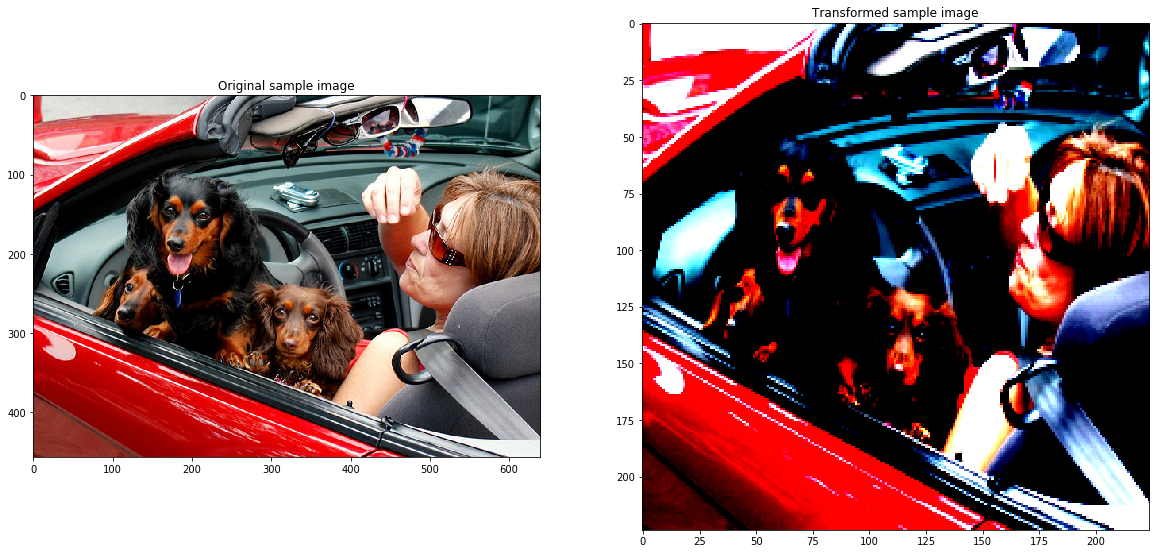

A trio of dogs sitting in their owner's lap in a red convertible.


In [11]:
# Visualize both original sample image before pre-processing and transformed sample image after pre-processing.
plt.figure(figsize=(20,10)) # set width and height of the figure to 20 x 10 inches
plt.subplot(121)
plt.imshow(orig_image)
plt.title('Original sample image')
plt.subplot(122)
plt.imshow(np.transpose(transformed_image, (1, 2, 0))) # transpose image swapping color channel to the back
plt.title('Transformed sample image')
plt.show()

print(caption_sentence)

In [12]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features => reshape to [batch_size, embed_size].
features = encoder(image)

# Get index for the stop word from the vocabulary
# stop_idx = data_loader.dataset.vocab.word2idx[data_loader.dataset.vocab.end_word]

# Pass the embedded image features through the model to get a predicted caption.
# output = decoder.argmax_sample(features, stop_idx=stop_idx)
output = decoder.argmax_sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 371, 130, 224, 39, 3, 869, 21, 3, 322, 323, 18, 1]


In [13]:
def clean_sentence(output):
    # Get trained index-to-word dictionary from current data loader to translate tokenized words of image caption
    idx2word = dict(list(data_loader.dataset.vocab.idx2word.items())[:])
    
    # Translate tokenized output to words omitting special words {0: '<start>', 1: '<end>', 2: '<unk>'}
    caption_in_words = []
    caption_in_words.extend([idx2word[idx] for idx in output if idx not in [0, 1, 2]])
    caption_in_words[0] = caption_in_words[0].capitalize()
    sentence = TreebankWordDetokenizer().detokenize(caption_in_words)
    
    # Return caption sentence
    return sentence

In [14]:
print('Ground truth image caption: ', clean_sentence(caption))
print('Predicted image caption:    ', clean_sentence(output))

Ground truth image caption:  A trio of dogs sitting in their owner's lap in a red convertible.
Predicted image caption:     A dog is sitting on a chair with a stuffed animal.


In [15]:
def compare_prediction_with_ground_truth():
    
    # Obtain a (original image, transformed image, caption) tuple from single-step validation data loader
    orig_image, image, caption = next(iter(data_loader))
    
    # Convert tensors to numpy arrays
    orig_image = orig_image[0].numpy()
    transformed_image = image[0].numpy() # make a copy as image-tensor is needed as input for prediction
    caption = caption[0].numpy()
    
    # Move image to device and pass it through the Encoder-Decoder-Chain to obtain a predicted image caption
    image = image.to(device)
    with torch.no_grad():
        features = encoder(image)
        output = decoder.argmax_sample(features)
    
    # Obtain translations of tokenized ground truth and predicted image caption
    original_caption = clean_sentence(caption)
    predicted_caption = clean_sentence(output)
    
    # Plot original and transformed sample image
    plt.figure(figsize=(20,10)) # set width and height of the figure to 20 x 10 inches
    plt.subplot(121)
    plt.imshow(orig_image)
    plt.title('Original sample image')
    plt.subplot(122)
    plt.imshow(np.transpose(transformed_image, (1, 2, 0))) # transpose image swapping color channel to the back
    plt.title('Transformed sample image')
    plt.show()
    
    # Print tokenized ground truth and predicted image caption
    print(caption)
    print(output)
    print(' ')
    
    # Print ground truth and predicted image caption translated to words
    print('Ground truth image caption: ', original_caption)
    print('Predicted image caption:    ', predicted_caption)
    return predicted_caption, original_caption

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


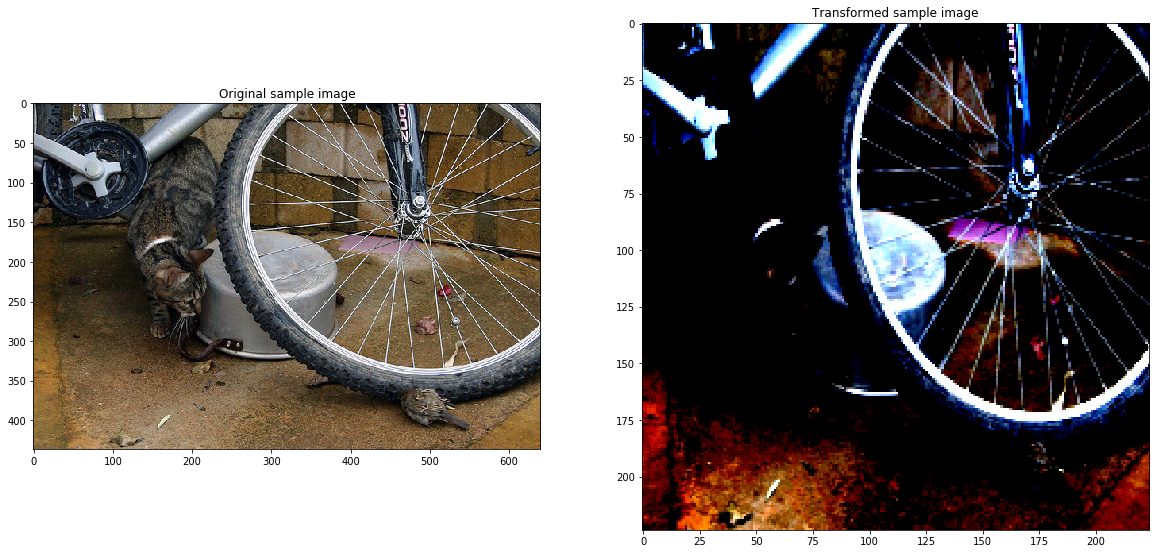

[   0   32  115  130   53  192   32  140 1017   32 1922   18    1]
[0, 3, 129, 131, 364, 161, 3, 209, 935, 18, 1]
 
Ground truth image caption:  The cat is walking around the bike towards the bird.
Predicted image caption:     A bicycle parked next to a parking meter.


In [16]:
_, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


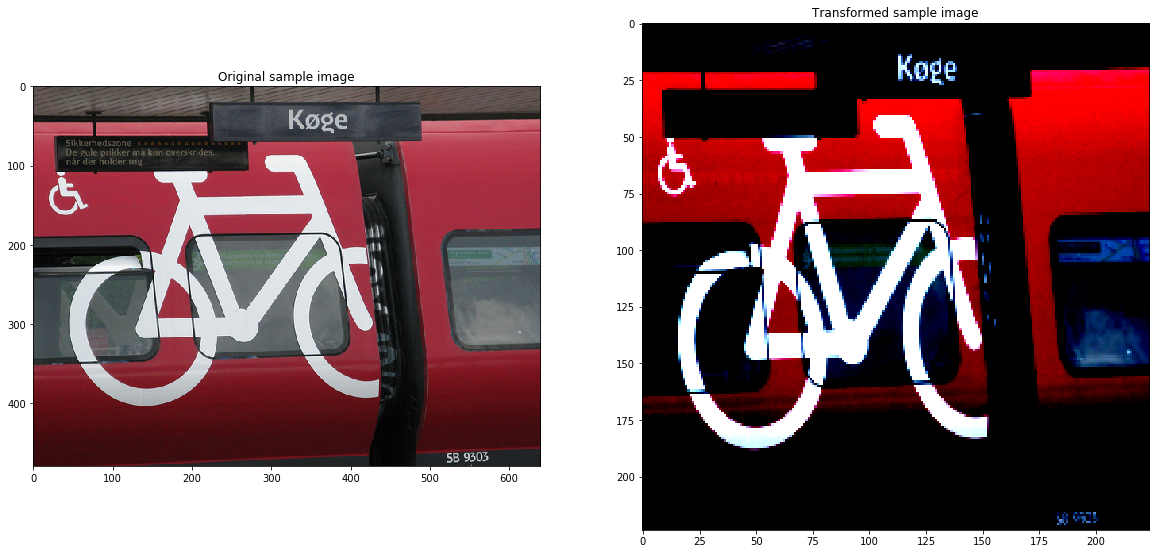

[   0    3   35  855   64  184   21   51 5017 4423  120    6  130 3554
 1396   18    1]
[0, 3, 35, 459, 1102, 174, 897, 54, 3, 33, 18, 1]
 
Ground truth image caption:  A red train that along with people will transport bicycles and is wheelchair accessible.
Predicted image caption:     A red double decker bus driving down a street.


In [17]:
_, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


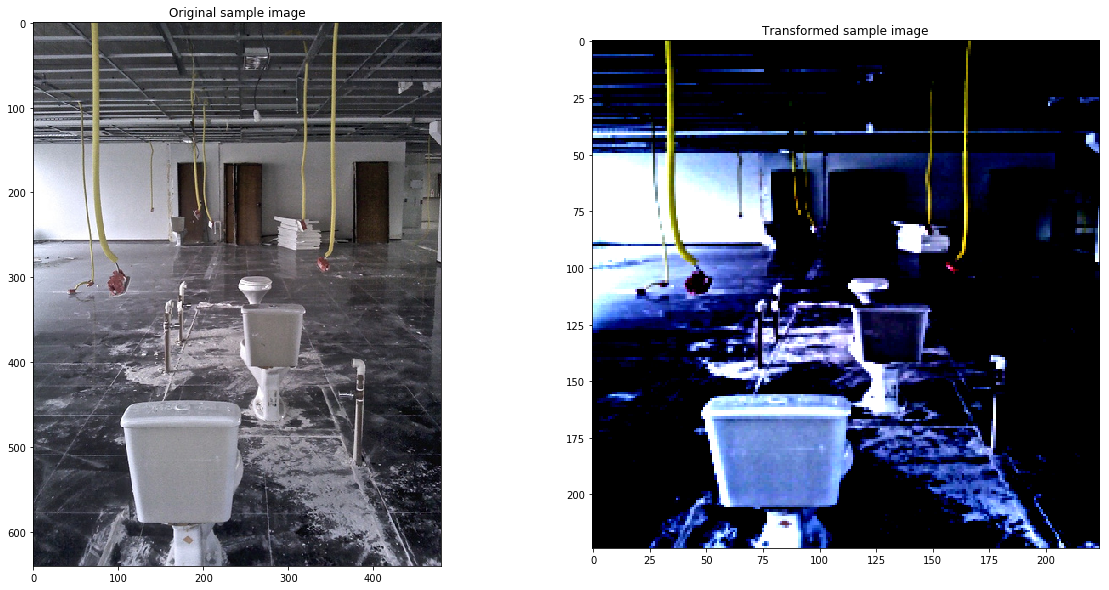

[   0    3 1519   13 1756   77    3 5084   13  251 3283    1]
[0, 3, 20, 112, 21, 3, 1824, 13, 762, 39, 46, 1]
 
Ground truth image caption:  A row of toilets in a warehouse of some sort
Predicted image caption:     A white table with a vase of flowers on it


In [18]:
_, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


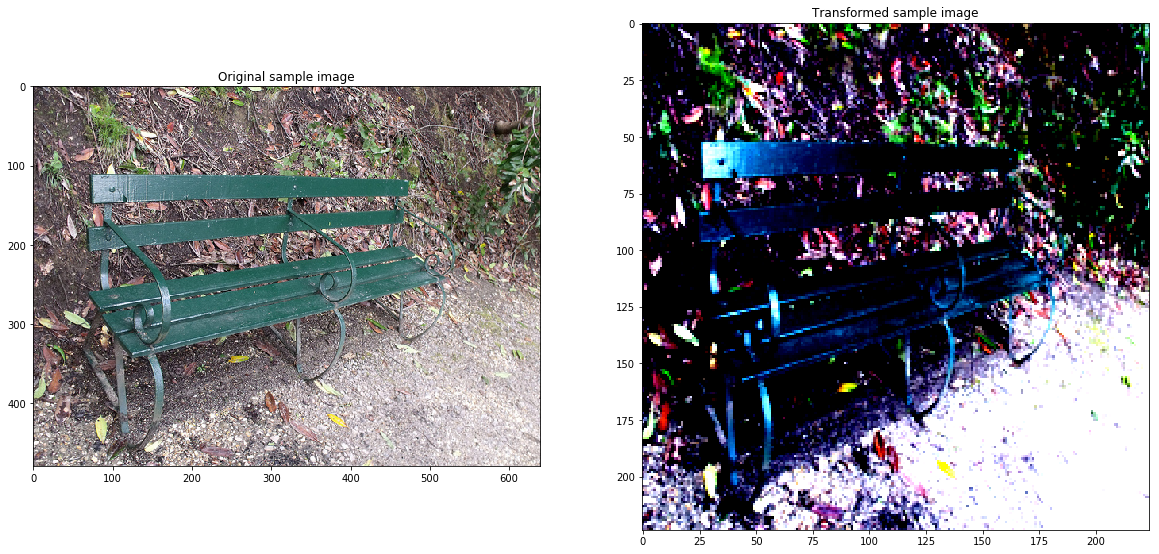

[   0    3   74  584  123  767  132  111   32  519   13   47 5318   18
    1]
[0, 3, 132, 224, 77, 32, 392, 13, 3, 767, 18, 1]
 
Ground truth image caption:  A metal dark green park bench at the base of an incline.
Predicted image caption:     A bench sitting in the middle of a park.


In [19]:
_, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


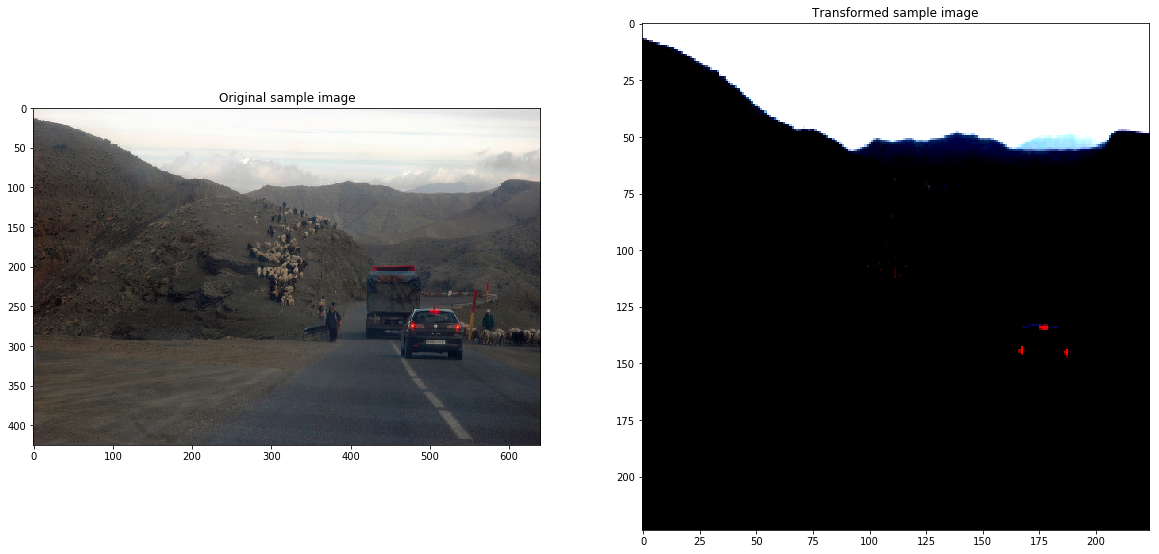

[   0    2 1827  102 3984   31    3 2058  176 6658 1255  924 1583  102
 3766   18    1]
[0, 3, 36, 130, 131, 39, 32, 185, 13, 32, 40, 18, 1]
 
Ground truth image caption:  Move their sheep across a highway as vehicular traffic passes between their flock.
Predicted image caption:     A car is parked on the side of the road.


In [20]:
_, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


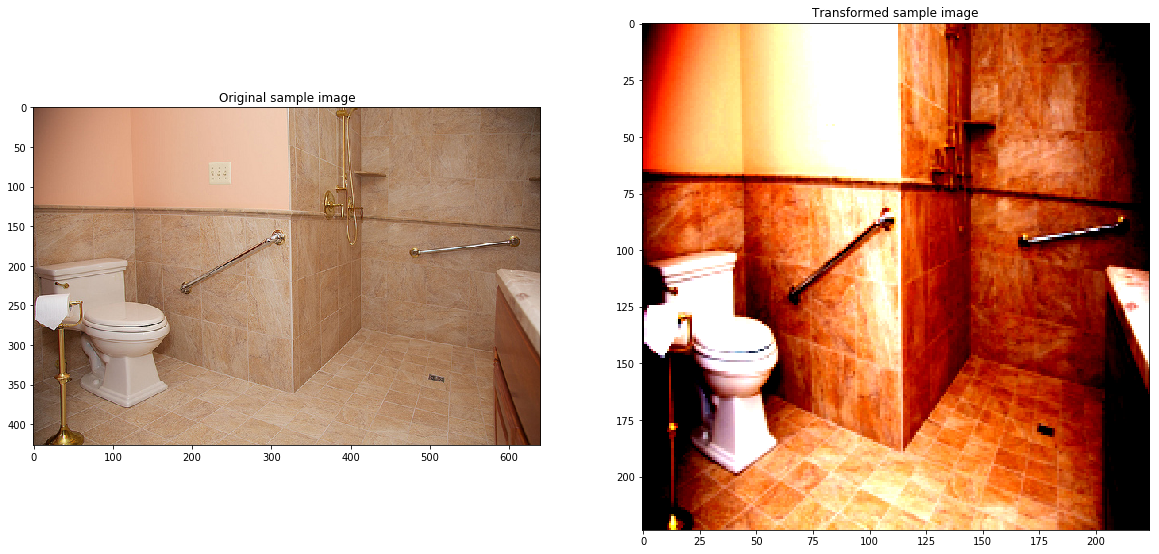

[  0   3  20  57 224  77   3  10 364 161   3  56  18   1]
[0, 3, 10, 21, 3, 57, 86, 56, 86, 6, 3, 151, 18, 1]
 
Ground truth image caption:  A white toilet sitting in a bathroom next to a sink.
Predicted image caption:     A bathroom with a toilet, sink, and a shower.


In [21]:
_, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


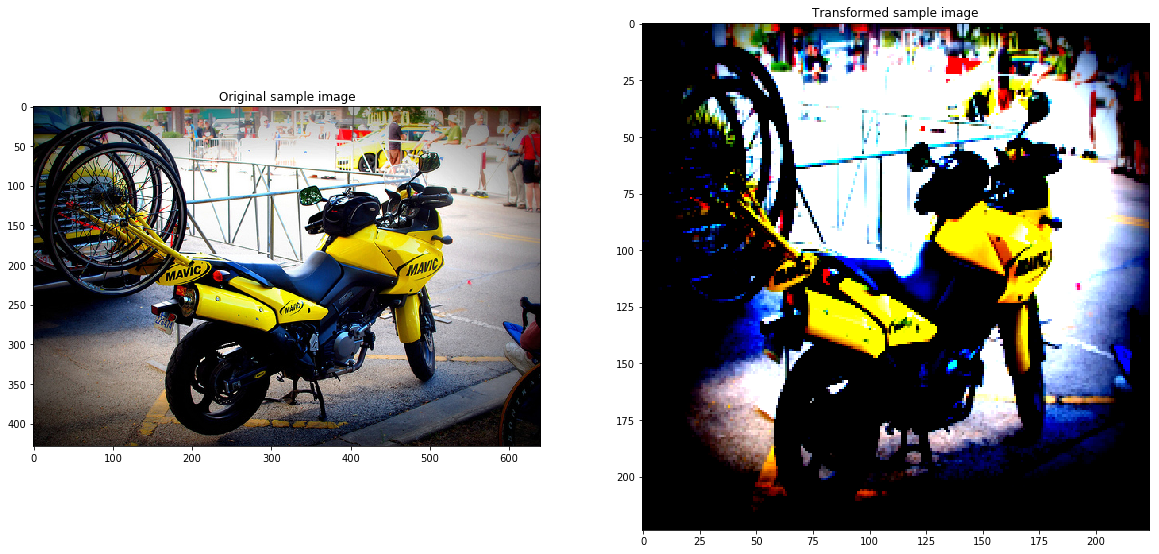

[   0    3  896  130  131   21   73  129  862  630  161   16 2111   18
    1]
[0, 3, 896, 131, 39, 32, 185, 13, 32, 40, 18, 1]
 
Ground truth image caption:  A motorcycle is parked with several bicycle tires attached to its rear.
Predicted image caption:     A motorcycle parked on the side of the road.


In [22]:
_, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


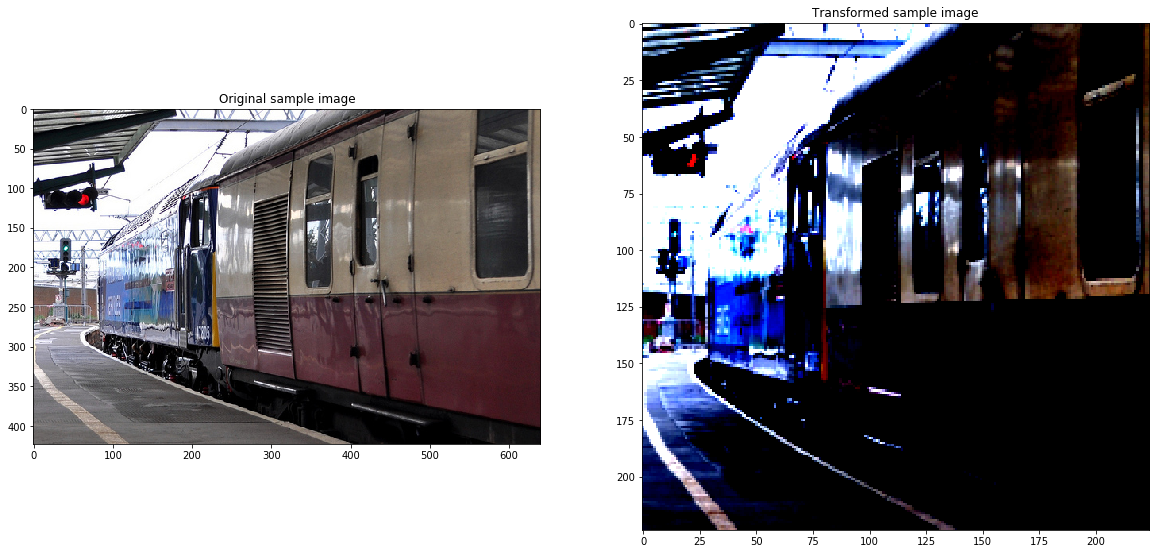

[  0   3 759 855  21 374 279 111   3 856  18   1]
[0, 3, 855, 130, 1200, 54, 32, 2486, 77, 32, 228, 18, 1]
 
Ground truth image caption:  A subway train with multiple cars at a station.
Predicted image caption:     A train is coming down the tracks in the city.


In [23]:
_, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


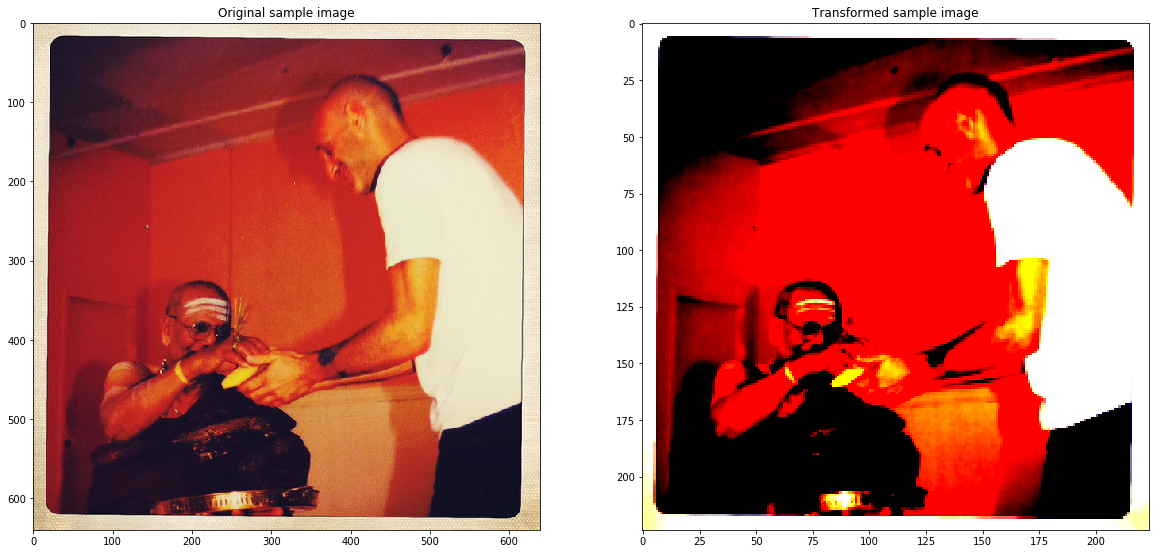

[   0    3  330   13   51   64   52 1580   77  185   13    3  522    1]
[0, 3, 91, 360, 3, 567, 407, 77, 3, 28, 18, 1]
 
Ground truth image caption:  A couple of people that are siting in side of a building
Predicted image caption:     A woman holding a teddy bear in a room.


In [24]:
_, _ = compare_prediction_with_ground_truth()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


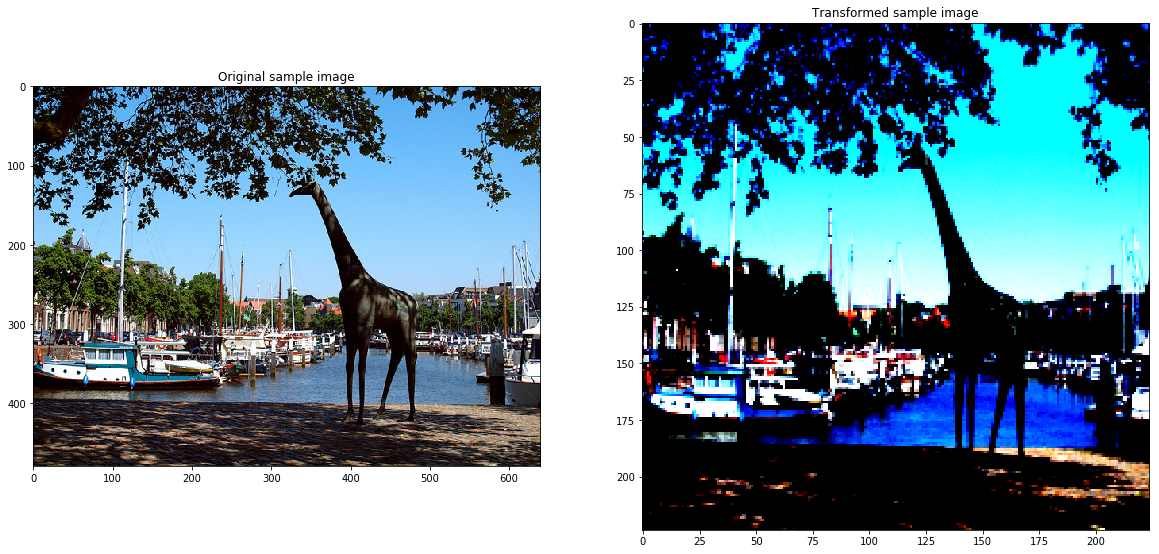

[   0    3 2437  130  170   79   32  278   21    3  210   13 3820  230
  294   18    1]
[0, 3, 335, 277, 130, 1951, 111, 3, 1197, 18, 1]
 
Ground truth image caption:  A giraffe is standing near the water with a lot of sailboats lined up.
Predicted image caption:     A large boat is docked at a pier.


In [25]:
_, _ = compare_prediction_with_ground_truth()